# Linear regression using Gradient Descent

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sb


## Load data

In [2]:
data = pd.read_csv("insurance.csv")
data


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Column's description

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance


In [3]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<AxesSubplot:xlabel='children', ylabel='Average charge'>

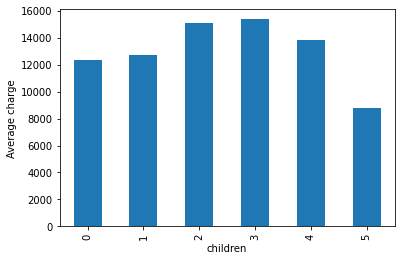

In [4]:
data.groupby(by=['children']).charges.mean().plot.bar(ylabel='Average charge')

<AxesSubplot:xlabel='sex', ylabel='Average charge'>

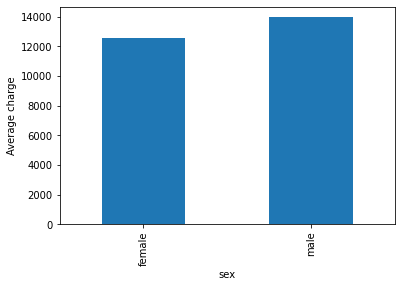

In [5]:
data.groupby(by=['sex']).charges.mean().plot.bar(ylabel='Average charge')

<AxesSubplot:xlabel='region', ylabel='Average charge'>

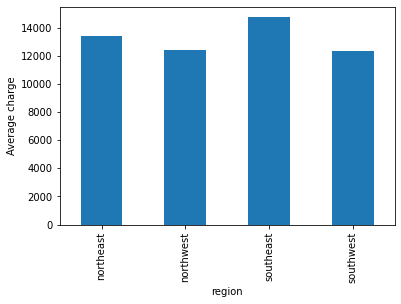

In [6]:
data.groupby(by=['region']).charges.mean().plot.bar(ylabel='Average charge')

## Split into train and test

In [7]:
# Convert sex, smoker and region columns into categorical columns for data set
dummies = data[["sex", "smoker", "region"]]
dummies = pd.get_dummies(dummies, drop_first=True)

# Drop original columns
data.drop(["sex", "smoker", "region"], axis=1, inplace=True)

# Concat dummies and data
data = pd.concat([data, dummies], axis=1)

# Save columns
columns = data.columns

# Standardize dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Convert back to dataframe
scaled_data = pd.DataFrame(scaled_data, columns=columns)

# Remove target column from dataset
target = scaled_data.pop('charges')

# Convert target array to numpy array
target = target.to_numpy()

# Convert dataframe into numpy matrix
scaled_data = scaled_data.to_numpy()

# Add constant column for x0 weight
X0 = np.ones(len(scaled_data))
scaled_data = np.column_stack((X0, scaled_data))

scaled_data.shape

(1338, 9)

In [8]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(
    scaled_data, target, test_size=0.33, random_state=42
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((896, 9), (442, 9), (896,), (442,))

## Least Squares

![alt text](leastsquares.png "Least Squares equation")

In [9]:
# Calculate weights according to the matrix notation of the derivatives
w = np.matmul(
    np.matmul(np.linalg.inv(np.matmul(x_train.T, x_train)), x_train.T), y_train
)
# Show weights
w

array([ 3.92083469e-04,  3.03470040e-01,  1.74786308e-01,  3.70071164e-02,
        5.00256933e-03,  7.90085612e-01, -1.20309329e-02, -3.25889523e-02,
       -2.84775031e-02])

In [10]:
def predict(x):
    return np.dot(x, w)

y_pred = predict(x_test)

r2_score(y_true=y_test, y_pred=y_pred)

0.7605492639270063

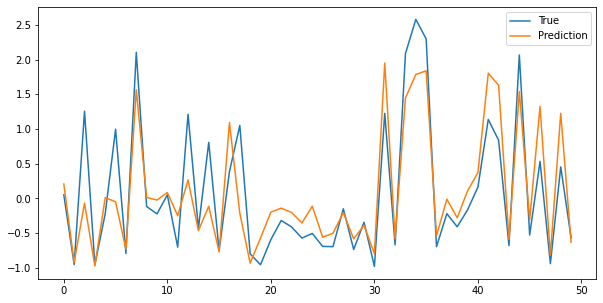

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(y_test[50:100], label="True")
plt.plot(y_pred[50:100], label="Prediction")
plt.legend()
plt.show()


## Define cost function

In [12]:
def mean_squeared_error(y_true, y_pred):
    return sum(((y_true - y_pred) ** 2)) / (2 * len(y_true))


## Batch Gradient Descent
### Calculate weights

![alt text](BatchGradientDescent.png "Gradient descent")

In [13]:
class BatchGradientDescent:
    def __init__(self, learning_rate: float, epochs: int):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.cost = []
        self.weights = None

    def predict(self, x):
        return [np.dot(self.weights, item) for item in x]

    def fit(self, x, y):
        self.weights = np.random.uniform(low=-1, size=len(x[0]))
        for _ in range(self.epochs):
            self.cost.append(mean_squeared_error(y, self.predict(x)))

            temp_weight = np.zeros(len(x[0]))

            for j in range(len(x[0])):  # Loop attributes
                for i in range(len(x)):  # Loop examples
                    temp_weight[j] += (np.dot(self.weights, x[i]) - y[i]) * x[i, j]

            self.weights -= self.learning_rate * (temp_weight / len(x))


bgd = BatchGradientDescent(learning_rate=0.01, epochs=200)
bgd.fit(x_train, y_train)
r2_score(y_test, bgd.predict(x_test))


0.6689895245197974

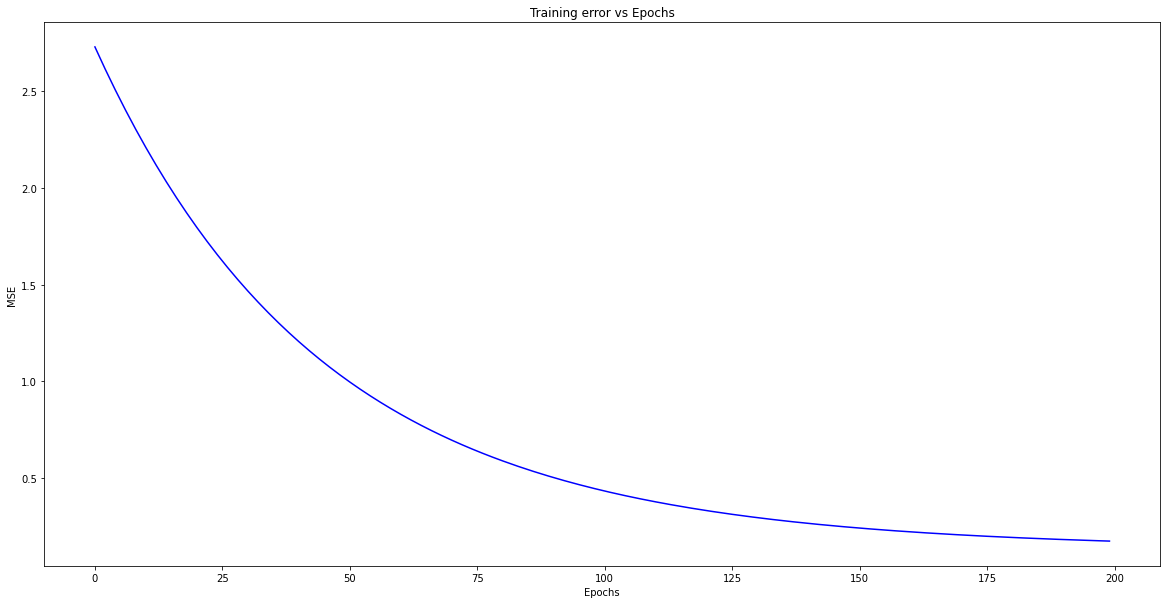

In [14]:
# Plot results
plt.figure(figsize=(20, 10))
plt.title("Training error vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(bgd.cost, color="blue")
plt.show()


## Stochastic Gradient Descent

![alt text](StochasticGradientDescent.png "Gradient descent")

In [15]:
class StochasticGradientDescent:
    def __init__(self, learning_rate: float, epochs: int):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.cost = []
        self.weights = None

    def predict(self, x):
        return [np.dot(self.weights, item) for item in x]

    def fit(self, x, y):
        self.weights = np.random.uniform(low=-1, size=len(x[0]))
        for _ in range(self.epochs):
            self.cost.append(mean_squeared_error(y, self.predict(x)))

            temp_weight = np.zeros(len(x[0]))

            for i in range(len(x)):  # Loop examples
                for j in range(len(x[0])):  # Loop attributes
                    temp_weight[j] = (np.dot(self.weights, x[i]) - y[i]) * x[i, j]

                self.weights -= self.learning_rate * temp_weight


sgd = StochasticGradientDescent(learning_rate=0.001, epochs=10)
sgd.fit(x_train, y_train)
r2_score(y_test, sgd.predict(x_test))


0.7609723512214415

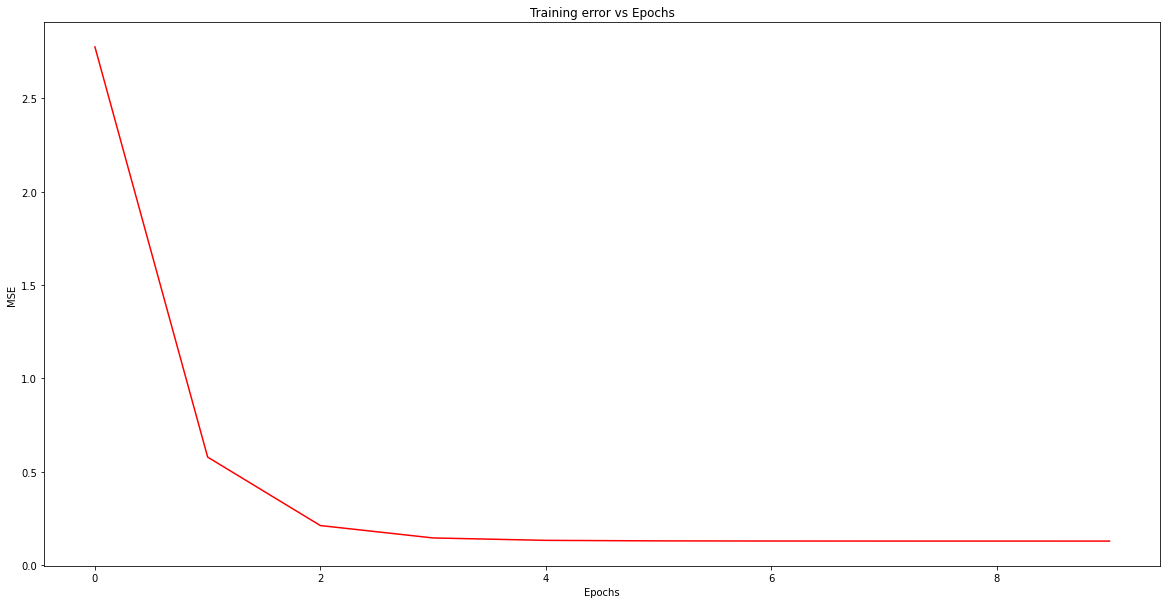

In [16]:
plt.figure(figsize=(20, 10))
plt.title("Training error vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(sgd.cost, color="red")
plt.show()


## Mini-batch Gradient Descent

![alt text](MiniBatchGradientDescent.png "Gradient descent")

In [17]:
class MiniBatchGradientDescent:
    def __init__(self, learning_rate: float, epochs: int, batch: int):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.cost = []
        self.batch = batch
        self.weights = None

    def predict(self, x):
        return [np.dot(self.weights, item) for item in x]

    def fit(self, x, y):
        self.weights = np.random.uniform(low=-1, size=len(x[0]))
        for _ in range(self.epochs):
            self.cost.append(mean_squeared_error(y, self.predict(x)))

            temp_weight = np.zeros(len(x[0]))

            for i in range(0, len(x), self.batch):  # Loop examples
                for j in range(len(x[0])):  # Loop attributes
                    for k in range(i, i + self.batch):
                        temp_weight[j] += (np.dot(self.weights, x[k]) - y[k]) * x[k, j]

                self.weights -= self.learning_rate * (temp_weight / self.batch)


mbgd = MiniBatchGradientDescent(learning_rate=0.001, epochs=10, batch=16)
mbgd.fit(x_train, y_train)
r2_score(y_test, mbgd.predict(x_test))

0.7593607934238737

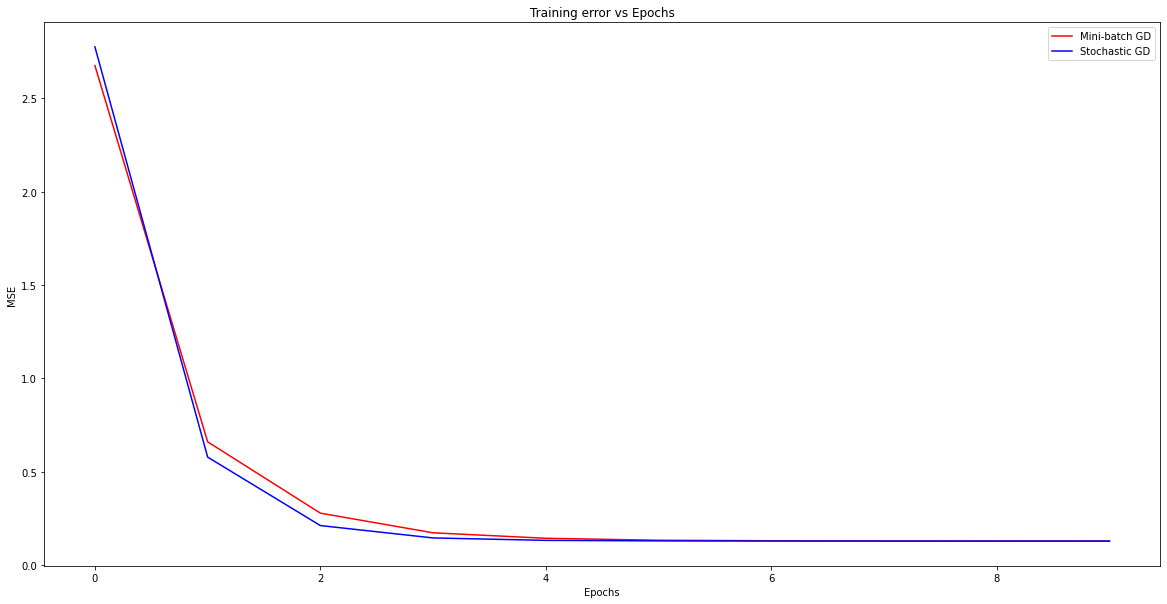

In [18]:
plt.figure(figsize=(20, 10))
plt.title("Training error vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(mbgd.cost, color="red", label="Mini-batch GD")
plt.plot(sgd.cost, color="blue", label="Stochastic GD")
plt.legend()
plt.show()
